In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x +5

In [3]:
f(3.0)

20.0

xs: [-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75] 

ys: [100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


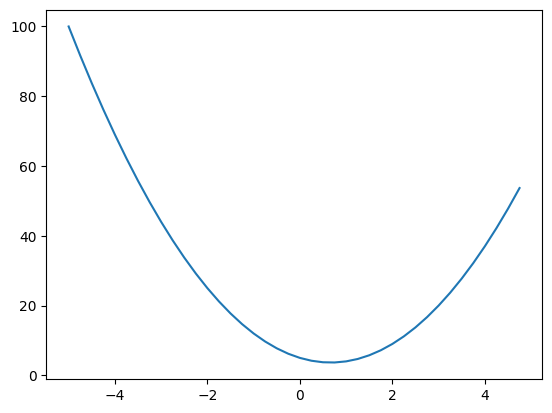

In [4]:
xs = np.arange(-5, 5, 0.25)
print(f"xs: {xs} \n")
ys = f(xs)
print(f"ys: {ys}")

plt.plot(xs, ys)

In [5]:
h = 0.001  # a small change
x = 3
print(f(x)) # function of x
print((f(x+h) - f(x))) # tells how much the func responded when nudge by h
print((f(x +h) - f(x)) / h) # norm by run to get the slope

20
0.01400300000000243
14.00300000000243


In [6]:
h = 0.01
x = 3
print(f(x+h))
print((f(x +h) - f(x))) # at some point of small value of h there is no change

20.140299999999996
0.14029999999999632


In [7]:
# lets get more example
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c #func of 3 scalar inputs
c +=h
d2 = a*b +c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)

d1 4.0
d2 4.01
slope 0.9999999999999787


In [26]:
class Value:
    def __init__(self, data, _children=(), _op = "", label = ""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        self = self if isinstance(self, Value) else Value(self)
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
      x = self.data
      out = Value(math.exp(x), (self,), "exp")

      def _backward():
        self.grad += out.data * out.grad
      out._backward = _backward

      return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [9]:
from graphviz import Digraph  # Corrected the import statement

def trace(root):
    # Build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:  # Assumes `v` has an attribute `_prev` which is iterable
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ("record") node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # Connect this node to the operation
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the operation node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


$$
Derivative: \lim x -> inf[f(x+h) - f(x)] / h
$$



In [10]:
#lim x --> inf [f(x+h) - f(x)] / h
def lol():

  h = 0.001

  a = Value(2.0, label = "a")
  b = Value(-3.0, label = "b")
  c = Value(10.0, label = "c")
  e = a*b; e.label = "e"
  d = e+c; d.label ="d"
  f = Value(-2.0, label="f")
  L = d*f; L.label = "L"
  L1 = L.data

  a = Value(2.0, label = "a")
  b = Value(-3.0, label = "b")
  b.data += h
  c = Value(10.0, label = "c")
  e = a*b; e.label = "e"
  d = e+c; d.label ="d"
  f = Value(-2.0, label="f")
  L = d*f; L.label = "L"
  L2 = L.data

  print((L2 - L1)/h)

lol()

-3.9999999999995595


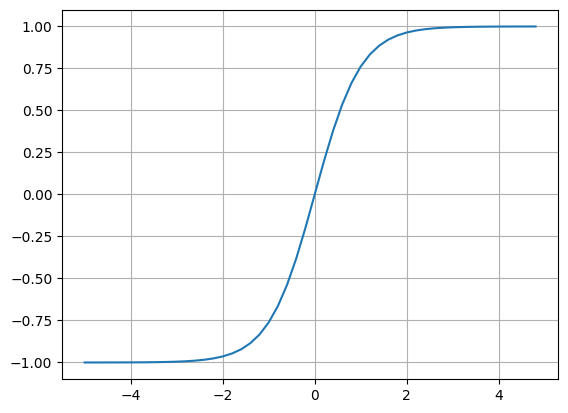

In [11]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)));plt.grid();

In [13]:
# manual backprop without backward function

o.grad = 1.0
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2
1 - o.data**2

0.49999979410757567

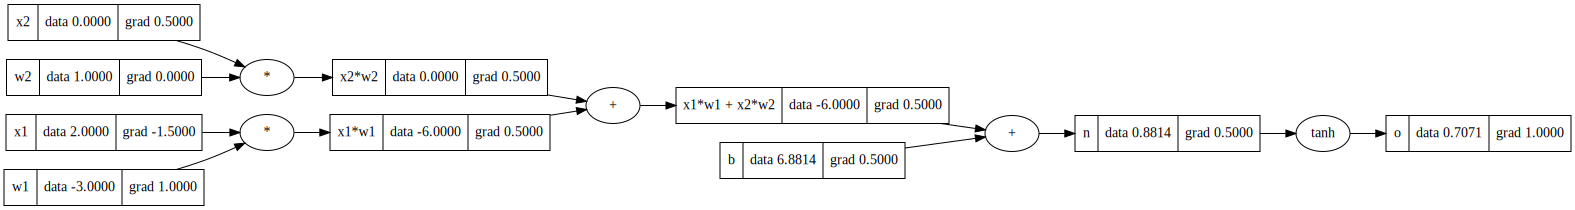

In [18]:
n.grad = 0.5

# + is just an distributor operator both gives 1 and 1*0.5 = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5

# again the + operator
x1w1.grad = 0.5
x2w2.grad = 0.5
draw_dot(o)

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_dot(o)

In [19]:
# bugs
a = Value(2.0, label='a')
b = a+a; b.label = "b"

b.grad = 1

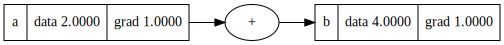

In [19]:
b._backward()
draw_dot(b)

# acutally while backprop 2 will the grad for the a
# here 1 it came cuz the same class value is over-writing again and again while performing forward pass of two same class

# solution: update the value by using += to stop over writting and instead it will update the values

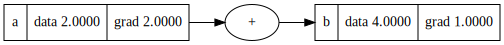

In [20]:
# after update the value class
b.backward()
draw_dot(b)

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373878195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o =n.tanh(); o.label = 'o'
o.backward()

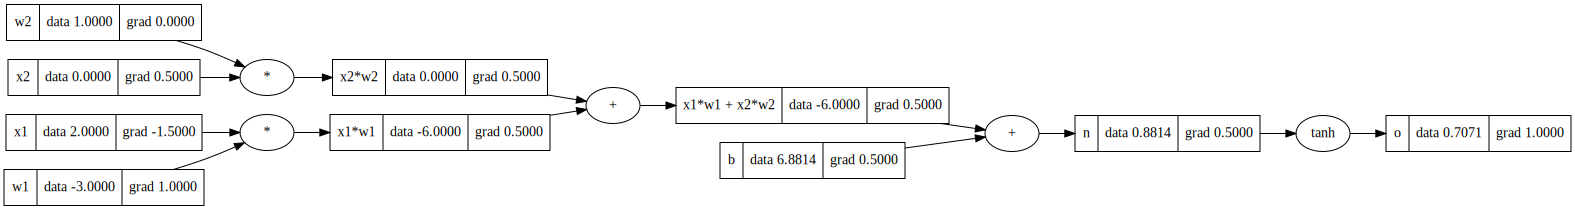

In [13]:
draw_dot(o)

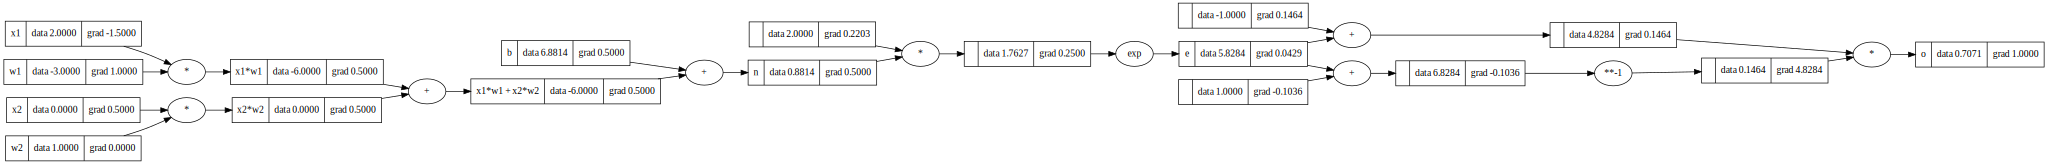

In [14]:
# breaking-down tanh

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373878195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ------------
e = (2*n).exp(); e.label ="e"
o = (e - 1) / (e + 1)
# ------------
o.label = 'o'
o.backward()

draw_dot(o)

# """
# got the same result as before breaking down the tanh
# so it doen't matter how we compute unless we can able to do forward and backward pass

# """

In [15]:
# The same above in pytorch
import torch

In [16]:
x1 = torch.tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double() ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 +b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-------------")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())


0.7071066904050358
-------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [17]:
o.data, o.data.item()

(tensor([0.7071], dtype=torch.float64), 0.7071066904050358)

In [18]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w*x + b
    act = sum((wi*xi for wi, xi in zip(self.w , x)), self.b)
    out = act.tanh()
    return out

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

class MLP:
  def __init__(self, nin, nouts): # nouts -List[no.of.neurons in each layer] --> [32, 64, 64]
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)


Value(data = 0.8975441649973604)

In [20]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred
# draw_dot(n(x))


# how to we tuned it to produce the desired targets

[Value(data = 0.8975441649973604),
 Value(data = -0.20788629952031362),
 Value(data = 0.7983227983290566),
 Value(data = 0.8341043097468122)]

In [27]:
# single num to calculate the total performance of the NN

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

# want to minimize the loss

Value(data = 3.8994275796483406)

In [28]:
loss.backward()

In [35]:
n.layers[0].neurons[0].w[0].grad

0.2367466459567109

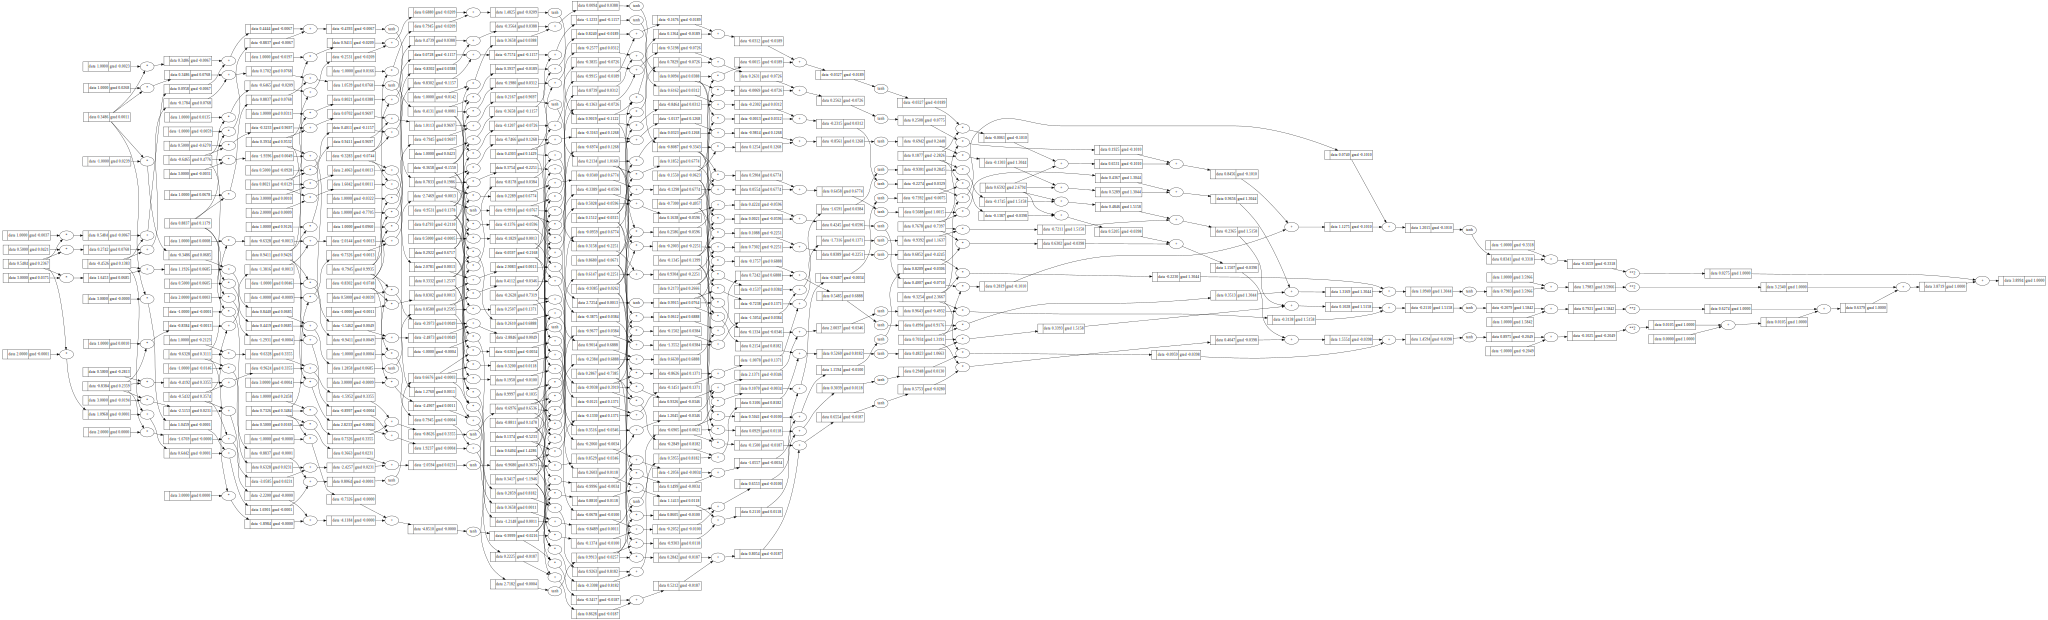

In [36]:
draw_dot(loss)